In [1]:
#import tools for web scraping:
from requests import get
from bs4 import BeautifulSoup
import os
import pandas as pd

#group imports
import env
import acquire
import constants_prepare

import json
from typing import Dict, List, Optional, Union, cast
import requests

#visualizations:
import matplotlib.pyplot as plt
import seaborn as sns

_____________________________________________________________________________

## Exploring Ubuntu:

In [2]:
ubuntu = pd.read_json('ubuntu_data.json')

In [3]:
ubuntu.head()

,repo,language,readme_contents
0,dockerfile/ubuntu,Shell,## Ubuntu Dockerfile\n\n\nThis repository cont...
1,boxcutter/ubuntu,Shell,# Packer templates for Ubuntu written in legac...
2,wszqkzqk/deepin-wine-ubuntu,C,# Deepin wine for Ubuntu and Debian\n\n## 一、项目...
3,fcwu/docker-ubuntu-vnc-desktop,HTML,# docker-ubuntu-vnc-desktop\n\n[![Docker Pulls...
4,docker-32bit/ubuntu,Shell,ubuntu\n======\n\nBuild a docker image for ubu...


#### Normalizing the data:

In [4]:
import unicodedata
import re

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

In [5]:
#to view just one of the readme docs and see what kind of normalizing is needed:
soup = BeautifulSoup(ubuntu.readme_contents.iloc[10], 'html.parser')
soup

Ubuntu 18.04 CIS STIG

[![Build Status](https://travis-ci.com/florianutz/Ubuntu1804-CIS.svg?branch=master)](https://travis-ci.com/florianutz/Ubuntu1804-CIS)
[![Ansible Role](https://img.shields.io/badge/role-florianutz.Ubuntu1804--CIS-blue.svg)](https://galaxy.ansible.com/florianutz/Ubuntu1804-CIS/)

Configure Ubuntu 18.04 machine to be CIS compliant. Level 1 and 2 findings will be corrected by default.

This role **will make changes to the system** that could break things. This is not an auditing tool but rather a remediation tool to be used after an audit has been conducted.

## IMPORTANT INSTALL STEP

If you want to install this via the `ansible-galaxy` command you'll need to run it like this:

`ansible-galaxy install -p roles -r requirements.yml`

With this in the file requirements.yml:

```
- src: https://github.com/florianutz/Ubuntu1804-CIS.git
```

Based on [CIS Ubuntu Benchmark v2.0.1 - 01-03-2020 ](https://www.cisecurity.org/cis-benchmarks/).

This repo originated from work do

In [6]:
#getting an overall view of the data:
ubuntu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             1100 non-null   object
 1   language         964 non-null    object
 2   readme_contents  1100 non-null   object
dtypes: object(3)
memory usage: 25.9+ KB


In [7]:
#looking at any nulls:
ubuntu.isnull().sum()

repo                 0
language           136
readme_contents      0
dtype: int64

In [8]:
#seeing the unique languages:
ubuntu.language.value_counts()

Shell               502
Python              105
Dockerfile           51
C                    44
C++                  34
HTML                 33
Ruby                 27
JavaScript           24
Jinja                18
Go                   12
PHP                  12
CSS                  11
Makefile             11
Puppet               10
HCL                   9
Jupyter Notebook      8
Vim script            6
Dart                  6
PowerShell            4
QML                   4
Nginx                 3
Perl                  3
Objective-C           3
Scheme                2
C#                    2
TeX                   2
SCSS                  2
Haskell               2
R                     2
M4                    1
YAML                  1
Rich Text Format      1
Vue                   1
Java                  1
Scala                 1
Smarty                1
Groovy                1
VimL                  1
Emacs Lisp            1
Tcl                   1
Batchfile             1
Name: language, 

______________________________________________

## Ubuntu Languages:

In [52]:
#looking at the overall percentages of the top 10 languages used in Ubuntu repos:
language_counts=ubuntu.language.value_counts(normalize=True).head(10)
language_counts

Shell         0.520747
Python        0.108921
Dockerfile    0.052905
C             0.045643
C++           0.035270
HTML          0.034232
Ruby          0.028008
JavaScript    0.024896
Jinja         0.018672
Go            0.012448
Name: language, dtype: float64

In [37]:
#creating a df of the percentages to prep for charts:
temp = pd.DataFrame({'language' : language_counts.index, 'percentage': language_counts.values})
temp

,language,percentage
0,Shell,0.520747
1,Python,0.108921
2,Dockerfile,0.052905
3,C,0.045643
4,C++,0.035270
5,HTML,0.034232
6,Ruby,0.028008
7,JavaScript,0.024896
8,Jinja,0.018672
9,Go,0.012448


<AxesSubplot:xlabel='language', ylabel='percentage'>

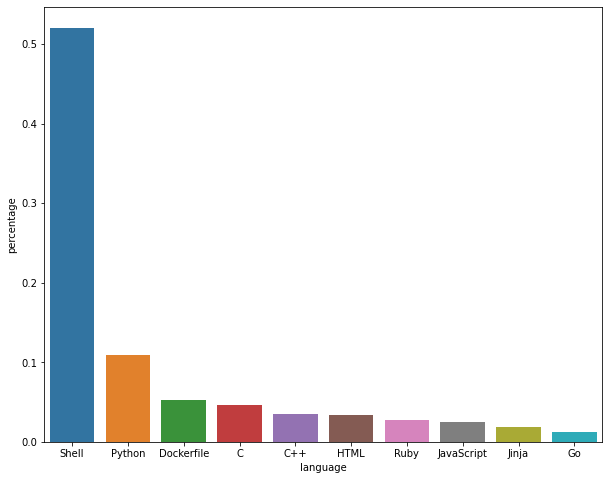

In [49]:
#plotting out the percentages of the Top 10 languages used in Ubuntu repos:
plt.figure(figsize=(10,8))
sns.barplot(data=temp, x = 'language', y = 'percentage')

## Cleaning the Data:

Steps to parsing data:
- 1) Convert text to all lower case for normalcy.
- 2) Remove any accented characters, non-ASCII characters.
- 3) Remove special characters and html and linux related words.
- 4) Stem or lemmatize the words.(stem = "if b, then c")
- 5) Remove stopwords.(if, and, the, etc)
- 6) Store the clean text and the original text for use in future notebooks.

In [53]:
ADDITIONAL_STOPWORDS = [
    'sudo',
    'distro',
    'linux',
    'aptget',
    'ubuntu',
    'debian',
    'arch',
    'archlinux',
    'git',
    'root',
    'img'
] 

def clean_data(text):
    ps = nltk.porter.PorterStemmer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[\(<\"]?http.*[\)>\"\s]', ' ', text).split()
    words = [re.sub(r'[^\w\s]', '', text) for text in words]
    try:
        while True:
            words.remove('')
    except ValueError:
        pass
    
    return [ps.stem(word) for word in words if word not in stopwords]

In [54]:
#grabbing text from df:
ubuntu_corpus = ' '.join(ubuntu['readme_contents'])
ubuntu_corpus[:100]

'## Ubuntu Dockerfile\n\n\nThis repository contains **Dockerfile** of [Ubuntu](http://www.ubuntu.com/) f'

In [55]:
#creating a list 
ubuntu_corpus_list = clean_data(ubuntu_corpus)

______________________________

## Creating a df for the top 10 languages:

In [56]:
#finding all shell readmes:
shell_readme =' '.join(ubuntu[ubuntu['language'] == 'Shell'].readme_contents)

In [58]:
#renaming to shell words and cleaning data:
shell_words=clean_data(shell_readme)

In [59]:
#finding all python readmes:
python_readme =' '.join(ubuntu[ubuntu['language'] == 'Python'].readme_contents)

In [60]:
#renaming to python words and cleaning data:
python_words=clean_data(python_readme)

In [61]:
#finding all dockerfile readmes:
dockerfile_readme =' '.join(ubuntu[ubuntu['language'] == 'Dockerfile'].readme_contents)

In [62]:
#renaming to dockerfile words and cleaning data:
dockerfile_words=clean_data(dockerfile_readme)

In [63]:
#finding all C readmes:
C_readme =' '.join(ubuntu[ubuntu['language'] == 'C'].readme_contents)

In [64]:
#renaming to C words and cleaning data:
C_words=clean_data(C_readme)

In [66]:
#finding all C ++ readmes:
Cplus_readme =' '.join(ubuntu[ubuntu['language'] == 'C++'].readme_contents)

In [67]:
#renaming to C++ words and cleaning data:
Cplus_words=clean_data(Cplus_readme)

___________________________________

In [ ]:
#creating df on languages:
shell_words = ubuntu_df.clean(' '.join(ubuntu_df[ubuntu_df.language == 'Shell']))
python_words = ubuntu_df.clean(' '.join(ubuntu_df[ubuntu_df.language == 'Python']))
all_words = ubuntu_df.clean(' '.join(ubuntu_df.str.text))
